In [1]:
import numpy as np
import os
import pandas as pandas

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout 
from keras.callbacks import ModelCheckpoint 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import model_from_json
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.per_process_gpu_memory_fraction=0.3
session = tf.Session(config=config)

In [3]:
from config import csv_config as config
hdf5_path = config.HDF5_PATH
model_path = config.MODEL_PATH
weight_path = config.WEIGHT_PATH

In [4]:
seed = 7
np.random.seed(seed)

In [5]:
from helpers import CSVDatasetReader
reader = CSVDatasetReader(hdf5_path)
(X, Y) = reader.load()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)   
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

In [7]:
def smooth_curve(points, factor=0.9): 
    smoothed_points = [] 
    for point in points: 
        if smoothed_points: 
            previous = smoothed_points[-1] 
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else: smoothed_points.append(point) 
    return smoothed_points

In [8]:
epochs = 150

In [9]:
def model_deep():
    model = Sequential()
    model.add(Dense(768, input_dim=8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01),
                    activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(Dense(768, kernel_initializer='normal', activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [10]:
model_deep = model_deep()
#filepath=weight_path + "deep-sgd-weights-improvement.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
history = model_deep.fit(X_train, y_train, validation_split=0.33, epochs=epochs, batch_size=10, 
                         #callbacks=callbacks_list, 
                         verbose=0)
score = model_deep.evaluate(X_test, y_test, verbose=0)

dict_keys(['acc', 'val_acc', 'val_loss', 'loss'])


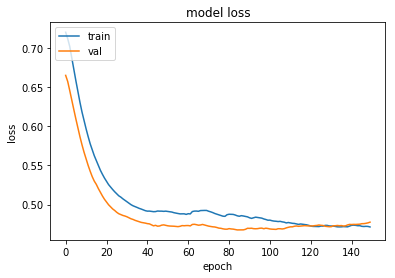

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(smooth_curve(history.history['loss']))
plt.plot(smooth_curve(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
print(score[1]*100)

81.1688314785


In [13]:
num_epochs = 150
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_scores = []
all_loss_histories = []
for train, test in kfold.split(X, Y):
    history = model_deep.fit(X[train], Y[train], epochs=num_epochs, batch_size=10, verbose=0)
    loss_history = history.history['loss']
    all_loss_histories.append(loss_history)
    # evaluate the model
    score = model_deep.evaluate(X[test], Y[test], verbose=0)
    all_scores.append(score[1]*100)

In [14]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(all_scores), np.std(all_scores)))

77.73% (+/- 2.63%)
